# Obligatorio Machine Learning para IA

### Ramiro Sanes y Joaquin Guerra

In [67]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage import data, color
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn.feature_extraction.image import PatchExtractor
from random import sample
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
import joblib
import imageio.v2 as imageio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from skimage.feature import hog
from skimage import exposure

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

Descomprimimos la carpeta con imágenes caseras "Background" y cargamos otras imágenes de scikit learn

In [2]:
import zipfile

with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
    zip_ref.extractall('Background')

In [3]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    #images.append(resize(img, (100,100),preserve_range=True))
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    #filename = "Background\\" + str(i) + ".jpg"
    filename = f"Background/{i}.jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    #images.append(resize(img, (100,100),preserve_range=True))
    images.append(resize(img, (100,100)))

Visualizamos las 40 imágenes (31 caseras + 9 de sklearn)

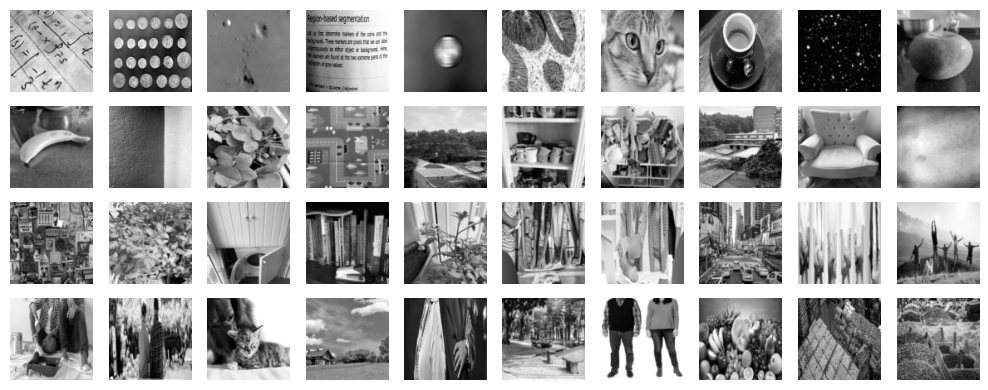

In [4]:
# Visualización
fig, ax = plt.subplots(4, 10, figsize=(10, 4), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Los rostros son de 64x64 por lo que vamos a usar parches de 64x64
size = (64, 64)

In [6]:
#Definimos funcion para extraer N parches de una imagen
def extract_patches(img,N,scale=1.0,patch_size = size):
    """
    Extrae N parches de una imagen
    :param image: Imagen de entrada
    :param N: Cantidad de parches a extraer
    :param scale: Escala de la imagen (1.0 = original)
    :param patch_size: Tamaño del parche
    :return: Parche extraido
    """
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        #patches = np.array([resize(patch, patch_size,preserve_range=True) for patch in patches])
        patches = np.array([resize(patch, patch_size) for patch in patches])

    
    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [7]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 150, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s]


(30000, 64, 64)

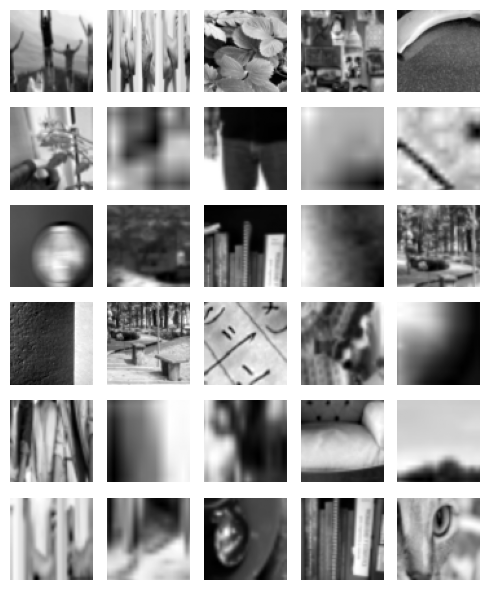

In [8]:
# Visualizamos una muestra
samples = sample(range(negative_patches.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [9]:
import zipfile

with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('Faces')

In [10]:
suffix = '.pgm'

all_files = os.listdir('Faces/Faces')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [11]:
faces = []
for filename in tqdm(pgm_files):
    path = os.path.join('Faces/Faces', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    faces.append(image)

100%|██████████| 12833/12833 [00:01<00:00, 7359.09it/s]


In [12]:
faces_array = np.stack(faces)

In [13]:
faces_array = faces_array / 255.0
print(faces_array[0])

[[0.52941176 0.54901961 0.56470588 ... 0.61960784 0.55686275 0.50196078]
 [0.52941176 0.55294118 0.56862745 ... 0.61960784 0.56078431 0.50980392]
 [0.53333333 0.56078431 0.57647059 ... 0.62352941 0.57254902 0.5254902 ]
 ...
 [0.37647059 0.38823529 0.38823529 ... 0.91764706 0.91764706 0.91372549]
 [0.34509804 0.35686275 0.35686275 ... 0.92156863 0.90980392 0.91372549]
 [0.32156863 0.32941176 0.33333333 ... 0.9254902  0.90196078 0.91372549]]


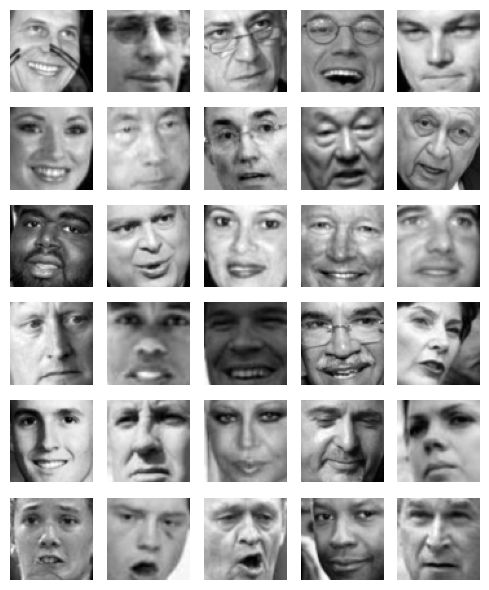

In [14]:
# Visualizamos una muestra
samples = sample(range(faces_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [15]:
print(type(faces_array))
print(type(negative_patches))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
X_faces = faces_array
y_faces = [1] * len(X_faces)  # Etiquetas para las imágenes de rostros
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)  # Etiquetas para las imágenes de fondo

In [17]:
print("Media - Rostros:", np.mean(X_faces))
print("Media - Fondos:", np.mean(X_fondos))

Media - Rostros: 0.5020220533773172
Media - Fondos: 0.4879995489787897


In [18]:
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])  # Etiquetas combinadas

In [19]:
print(X.shape, y.shape)

(42833, 64, 64) (42833,)


Aplanamos las imagenes

In [20]:
X_flatten = np.array([im.flatten() for im in tqdm(X, desc='Construyendo X')])

Construyendo X: 100%|██████████| 42833/42833 [00:00<00:00, 95098.53it/s]


In [21]:
X_faces_flatten = np.array([im.flatten() for im in tqdm(X_faces, desc='Construyendo X')])
X_fondos_flatten = np.array([im.flatten() for im in tqdm(X_fondos, desc='Construyendo X')])

Construyendo X: 100%|██████████| 30000/30000 [00:00<00:00, 221484.13it/s]


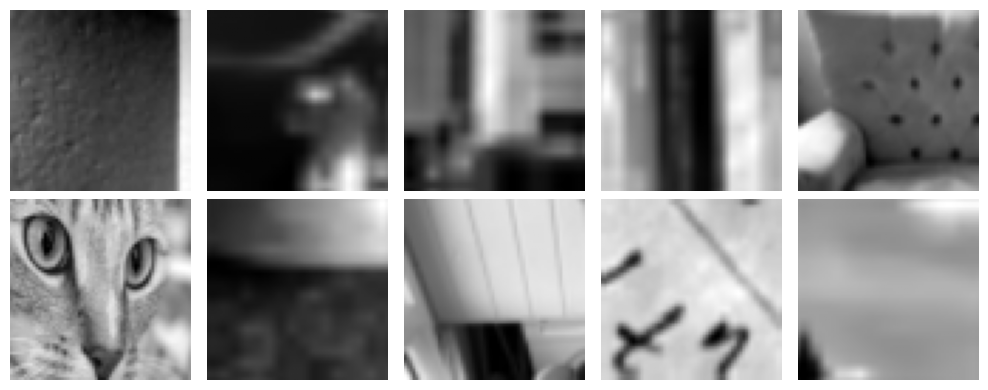

In [22]:
# Vuelvo X_faces a su forma original y muestro 10 random
X_faces_reshaped = X_fondos_flatten.reshape(-1, 64, 64)
samples = sample(range(X_faces_reshaped.shape[0]), 10)
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_faces_reshaped[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_flatten, y, test_size=0.1, random_state=42)

In [24]:
# normaliza la datita toda anasheiii
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Estimate batch size (experiment with this, e.g., 1000, 5000, 10000)
batch_size = 1000

pca_values = [100, 120, 130, 150, 200] # Your desired components
pca_dict = {}

for i in pca_values:
    print(f"Fitting IncrementalPCA with {i} components...")
    inc_pca = IncrementalPCA(n_components=i, whiten=True, batch_size=batch_size) # Adjust batch_size

    # Fit in batches
    for start in range(0, X_train_scaled.shape[0], batch_size):
        end = min(start + batch_size, X_train_scaled.shape[0])
        inc_pca.partial_fit(X_train_scaled[start:end])

    pca_dict[i] = inc_pca
    print(f"Successfully fitted IncrementalPCA with {i} components.")

print("\nIncremental PCA fitting process complete.")

Fitting IncrementalPCA with 100 components...
Successfully fitted IncrementalPCA with 100 components.
Fitting IncrementalPCA with 120 components...
Successfully fitted IncrementalPCA with 120 components.
Fitting IncrementalPCA with 130 components...
Successfully fitted IncrementalPCA with 130 components.
Fitting IncrementalPCA with 150 components...
Successfully fitted IncrementalPCA with 150 components.
Fitting IncrementalPCA with 200 components...
Successfully fitted IncrementalPCA with 200 components.

Incremental PCA fitting process complete.


Varianza explicada con 100 componentes: 0.9374742956545415
Varianza explicada con 120 componentes: 0.9458793413975928
Varianza explicada con 130 componentes: 0.9491680166155738
Varianza explicada con 150 componentes: 0.9549793306814495
Varianza explicada con 200 componentes: 0.9651464892742269


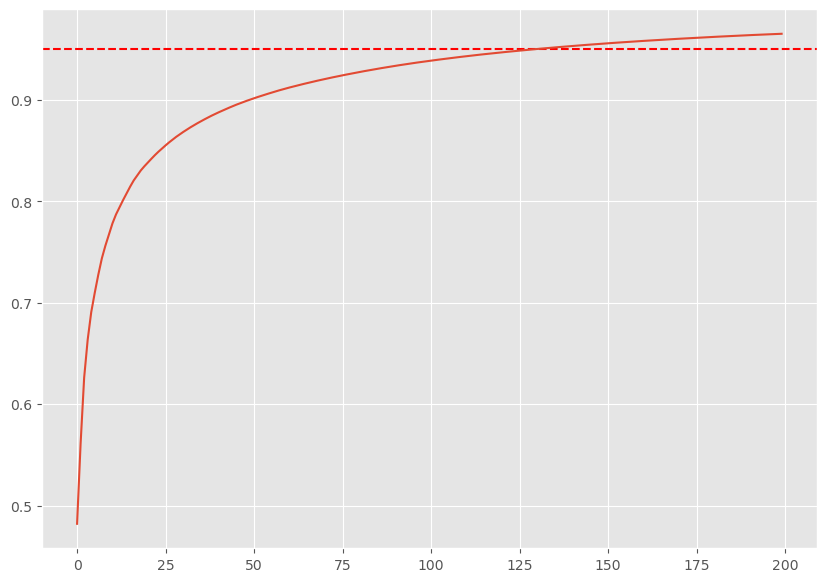

In [25]:
for i in pca_values:
    print(f"Varianza explicada con {i} componentes: {np.sum(pca_dict[i].explained_variance_ratio_)}")
    #print(f"Varianza explicada acumulada con {i} componentes: {np.cumsum(pca_dict[i].explained_variance_ratio_)}")

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_dict[200].explained_variance_ratio_), label=f'{200} componentes')
plt.show()

Tomamos 15 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada 

In [26]:
pca_final = pca_dict[150]

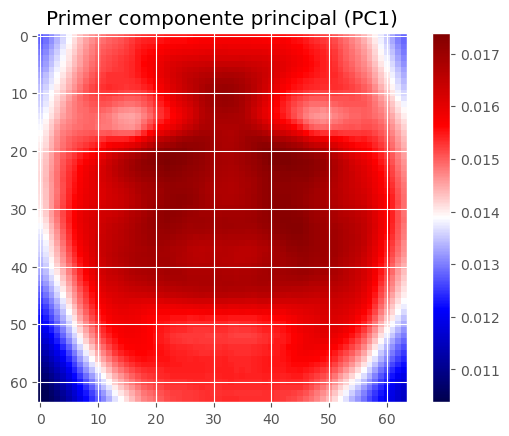

In [27]:
pc1 = pca_final.components_[0]  # Shape: (4096,)

# Visualizarlo como imagen (reshape 64x64)
plt.imshow(pc1.reshape(64, 64), cmap='seismic')
plt.title("Primer componente principal (PC1)")
plt.colorbar()
plt.show()

### Visualizamos las primeras componentes

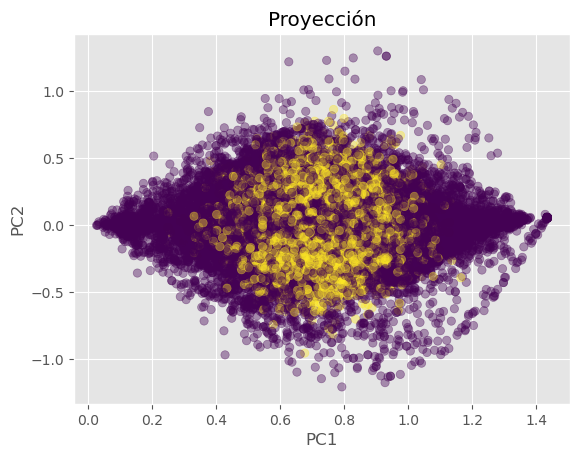

In [28]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

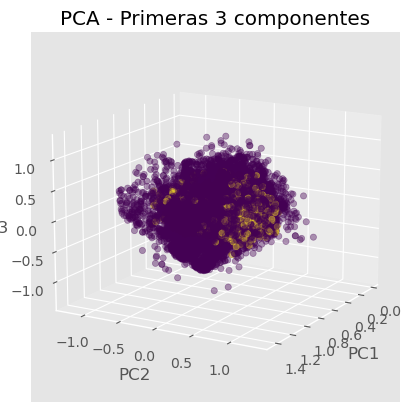

In [29]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

Podemos observar que con los 2 componentes principales, es notoria la división entre datos etiquetados como caras y datos etiquetados como fondos.
Cuando haciamos PCA solo en las caras, la cantidad de componenetes era 180, porque capturar la varianza de caras que son muy similares entre si, es mucho mas complejo que capturala en caras y fondos juntos.

In [30]:
df = pd.DataFrame(X_pca_train, columns=[f'PC{i+1}' for i in range(X_pca_train.shape[1])])
df['y'] = y_train
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,y
0,0.643924,0.037210,0.350982,0.157655,-0.006722,0.198483,0.147748,-0.082949,0.183710,-0.034120,...,0.004544,-0.003723,0.002190,-0.007601,-0.010274,-0.017697,0.035728,-0.029435,0.019139,0
1,0.885079,-0.290242,0.106428,0.422783,-0.286463,0.111296,0.053247,0.207798,-0.000056,0.003798,...,0.069751,0.003643,0.010335,-0.012584,0.001499,0.027922,0.028183,-0.076225,-0.109459,0
2,0.686142,-0.599150,0.271089,0.238830,0.243826,0.427939,0.038454,-0.541163,-0.063929,0.199149,...,-0.010260,0.004633,0.025317,-0.008292,-0.034916,-0.040217,-0.013550,-0.033454,0.013435,0
3,0.634307,0.125114,-0.138050,0.043140,-0.186706,0.269736,0.177719,0.089780,-0.051478,0.268251,...,-0.362489,-0.174913,-0.128650,0.243852,-0.319960,-0.175639,0.200000,-0.198712,0.071962,1
4,0.605596,0.001503,0.043020,0.138972,-0.036307,0.036462,0.014419,-0.019303,0.047825,0.034294,...,0.015717,0.018582,0.003709,0.007595,0.015513,-0.054450,0.059177,0.005762,-0.072004,0


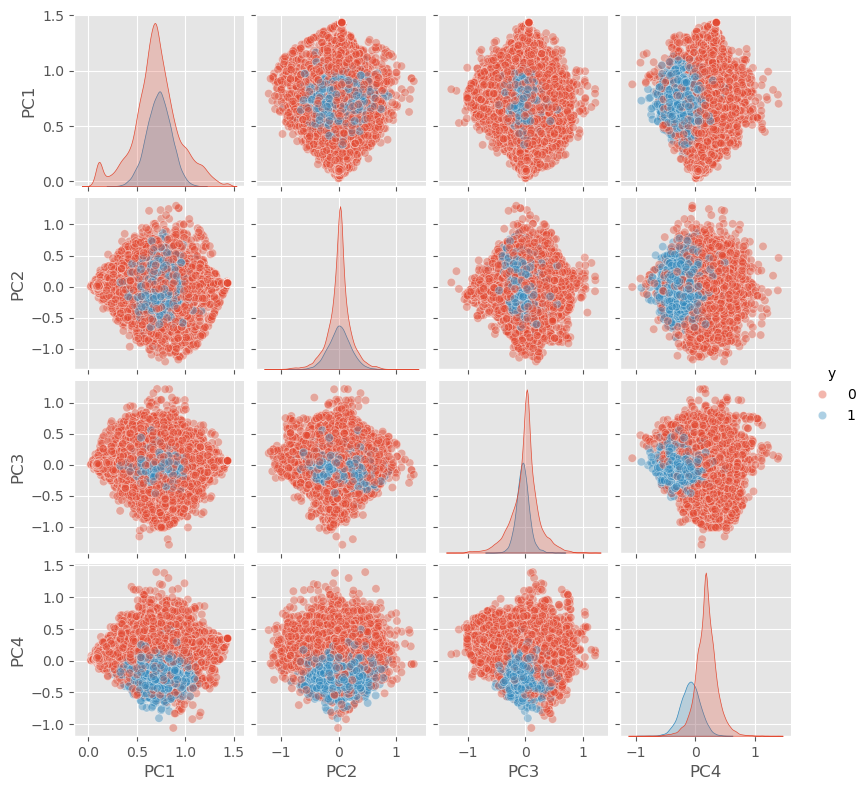

In [31]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

Observando los gráficos entendemos que 2 componentes capturan en gran medida la varianza entre los 2 subgrupos (caras y fondos), agregando las otras componentes, capturamos varianza que proviene de dentro de los subgrupos

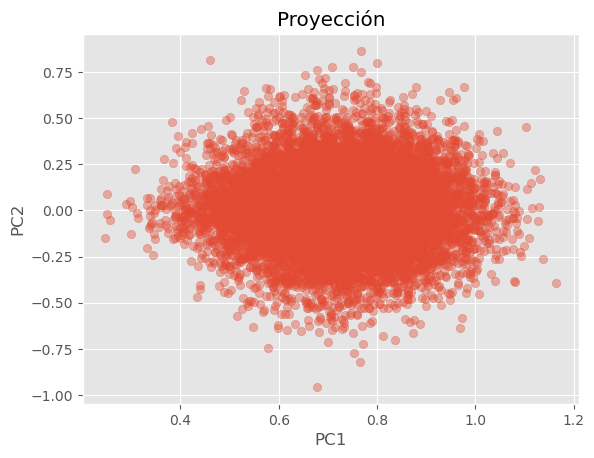

In [32]:
X_pca_caras = pca_final.transform(X_faces_flatten)

plt.scatter(X_pca_caras[:,0], X_pca_caras[:,1], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

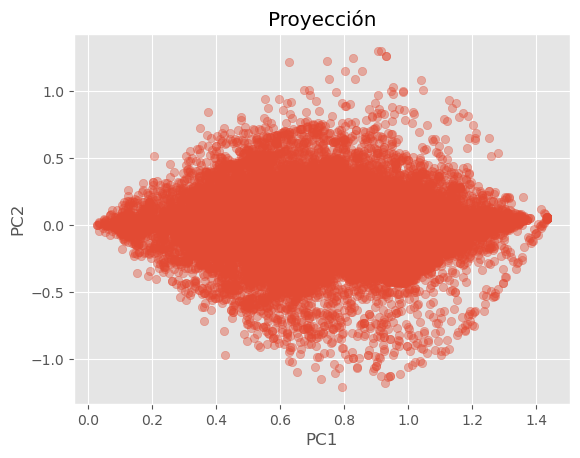

In [33]:
X_pca_fondos = pca_final.transform(X_fondos_flatten)

plt.scatter(X_pca_fondos[:,0], X_pca_fondos[:,1], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

### Modelo sencillo de clasificación

In [34]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 0.8693609319139336
Score con 5 profundidad: 0.9465096517470191
Score con 10 profundidad: 0.9581310776108711


In [35]:
X_pca_val = pca_final.transform(X_val)

In [36]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 0.8688141923436041
Accuracy en test con profundidad 5 : 0.9428104575163399
Accuracy en test con profundidad 10 : 0.9549486461251168


### Probamos en Test

In [37]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [38]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files_test = [filename for filename in all_files if filename.endswith(suffix)]

In [39]:
test_images = []
for filename in tqdm(pgm_files_test):
    path = os.path.join('Test/Test', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    test_images.append(image)

100%|██████████| 8000/8000 [00:01<00:00, 7355.07it/s]


In [40]:
test_array = np.stack(test_images)

In [41]:
test_array = test_array / 255.0

In [42]:
test_array.shape

(8000, 64, 64)

In [43]:
X_test_flatten = np.array([im.flatten() for im in tqdm(test_array, desc='Construyendo X')])

Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 232429.36it/s]


In [44]:
print("Media - Test:", np.mean(X_test_flatten))

Media - Test: 0.4885256642061123


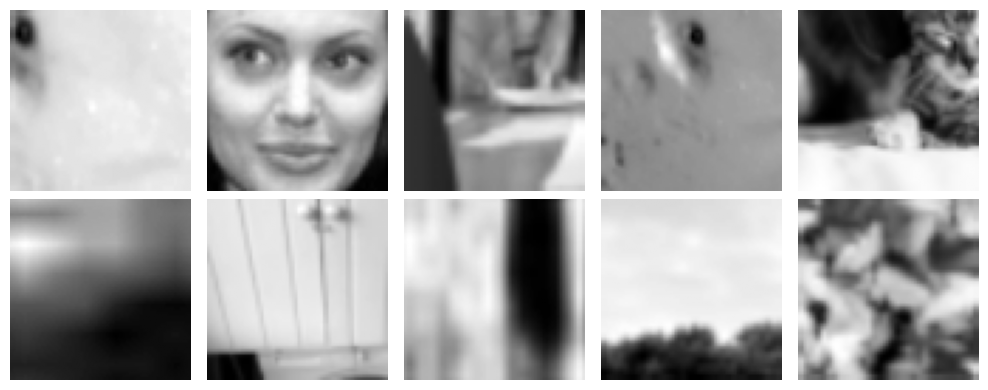

In [45]:
# vuelvo X_test_flatten a su forma original y muestro 10 random
X_test_reshaped = X_test_flatten.reshape(-1, 64, 64)
samples = sample(range(X_test_reshaped.shape[0]), 10)
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test_reshaped[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [46]:
X_test_pca = pca_final.transform(X_test_flatten)

In [47]:
y_test = tree_dict[10].predict(X_test_pca)

In [48]:
test_df = pd.DataFrame(X_test_flatten)

In [49]:
test_df['prediccion'] = y_test

In [50]:
test_df.value_counts('prediccion')

prediccion
0    7408
1     592
Name: count, dtype: int64

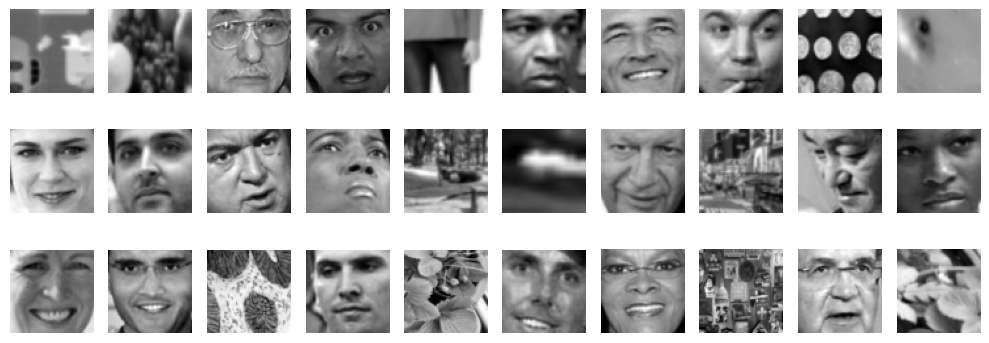

In [51]:
# muestro 10 imagenes de test_df que tengan prediccion 1
samples = sample(test_df[test_df['prediccion'] == 1].index.tolist(), 30)
fig, ax = plt.subplots(3, 10, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test_reshaped[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show() 

In [52]:
joblib.dump(tree_dict[5], 'modelos/modelo_tree_10_285v2.pkl')

['modelos/modelo_tree_10_285v2.pkl']

In [53]:
joblib.dump(pca_final, 'modelos/pca_final_150_285v2.pkl')

['modelos/pca_final_150_285v2.pkl']

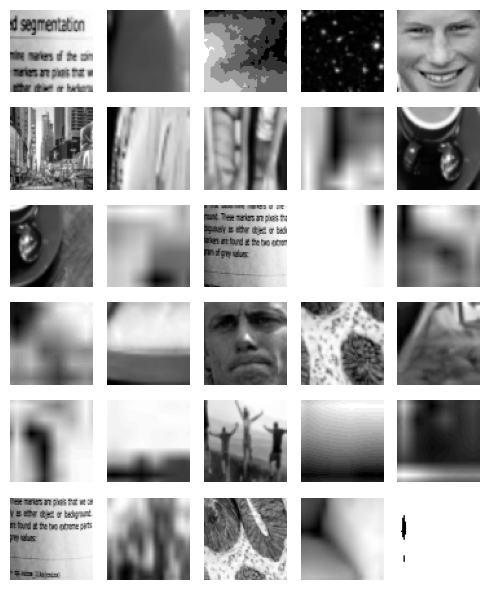

In [54]:
# Visualizamos una muestra
samples = sample(range(test_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

Prueba Random Forest


In [55]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [56]:
rf_model.fit(X_pca_train, y_train)

RandomForestClassifier(random_state=42)

In [57]:
test_accuracy = rf_model.score(X_pca_val, y_val)
print("Accuracy en test:", test_accuracy)

Accuracy en test: 0.972922502334267


Probamos en test Kaggle

In [58]:
y_pred_rf_model = rf_model.predict(X_test_pca)

In [59]:
df_pred_rf_model = pd.DataFrame(X_test_flatten)

In [60]:
df_pred_rf_model['prediccion'] = y_pred_rf_model

In [61]:
df_pred_rf_model.value_counts('prediccion')

prediccion
0    7613
1     387
Name: count, dtype: int64

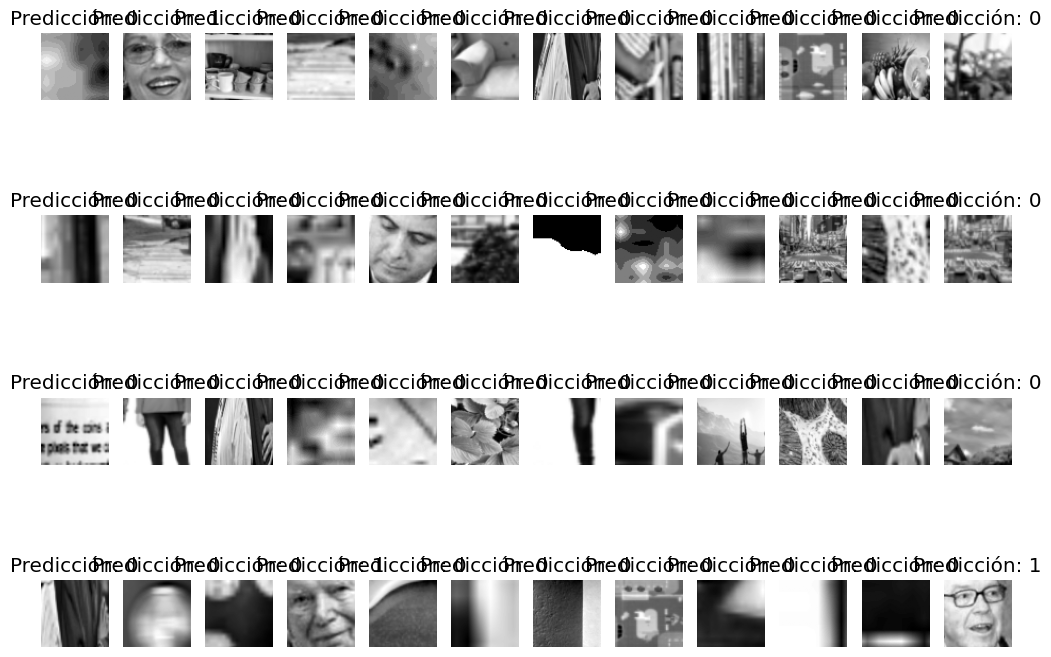

In [62]:
#imprimir las primeras 20 imagenes de test_array donde la prediccion es 1
samples = sample(range(test_array.shape[0]), 50)
fig, ax = plt.subplots(4, 12, figsize=(10, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
    axi.set_title(f"Predicción: {y_pred_rf_model[samples[i]]}")
plt.tight_layout()
plt.show()

In [63]:
test_df[0:50]['prediccion']

0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: prediccion, dtype: int64

In [64]:
# Obtengo de test_df los indices que tienen prediccion -1
indices_fondos = test_df[test_df['prediccion'] == -1].index
# Obtengo de test_df los indices que tienen prediccion 1
indices_caras = test_df[test_df['prediccion'] == 1].index

IndexError: index 0 is out of bounds for axis 0 with size 0

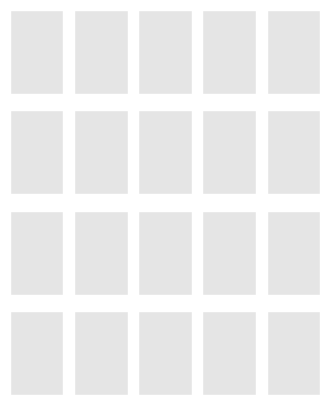

In [65]:
#muestro las primeras 10 imagenes de test_array que tienen prediccion -1 a partir de indices_fondos
fig, ax = plt.subplots(4, 5, figsize=(4, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()
for i in range(20):
    axes[i].imshow(test_array[indices_fondos[i]], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)


In [ ]:
gb_model.fit(X_pca_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
joblib.dump(gb_model, 'modelos/xgb_1.pkl')

['modelos/xgb_1.pkl']

Comparing HOG features between faces and backgrounds...


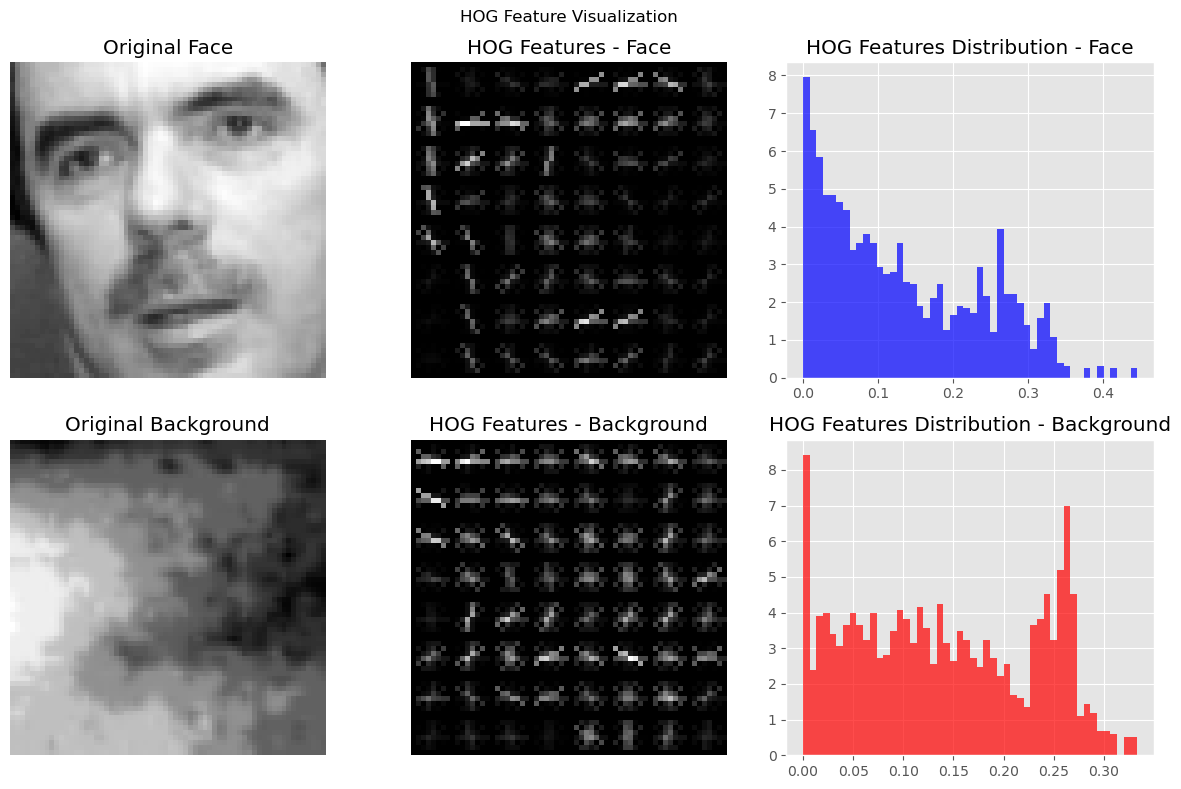


Extracting HOG features for all images...


Processing faces: 100%|██████████| 12833/12833 [00:44<00:00, 287.40it/s]

Processing backgrounds: 100%|██████████| 30000/30000 [01:42<00:00, 293.19it/s]




Training Random Forest classifier on HOG features...
HOG Features - Training accuracy: 1.000
HOG Features - Validation accuracy: 0.991
HOG Features - Training accuracy: 1.000
HOG Features - Validation accuracy: 0.991


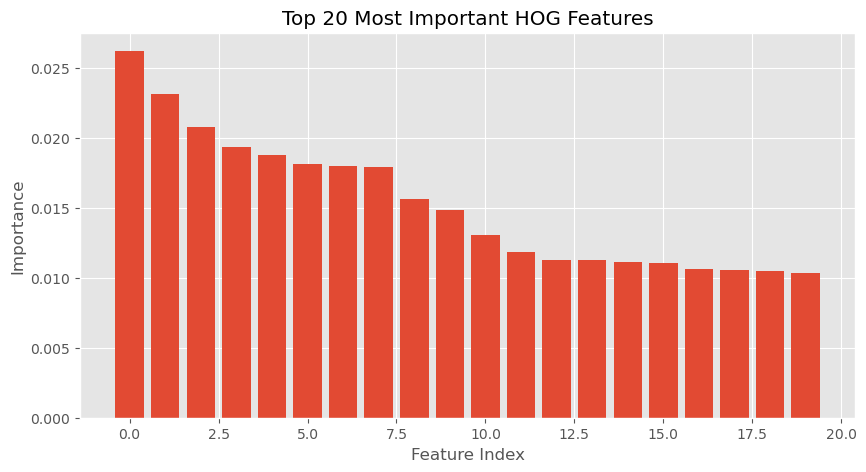


Saving HOG model...


['modelos/rf_hog_model.pkl']

In [68]:
# Add HOG feature extraction function
def extract_hog_features(image):
    """
    Extract HOG features from an image
    Parameters:
    - image: Input image (must be 2D array)
    Returns:
    - features: HOG features
    - hog_image: Visualization of HOG features
    """
    features, hog_image = hog(
        image,
        orientations=9,           # 9 orientation bins
        pixels_per_cell=(8, 8),   # 8x8 pixels per cell
        cells_per_block=(2, 2),   # 2x2 cells per block
        visualize=True,           # Return both features and visualization
        block_norm='L2-Hys'       # Block normalization method
    )
    return features, hog_image

print("Comparing HOG features between faces and backgrounds...")

# Visualize HOG features for a sample face and background
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('HOG Feature Visualization')

# Face image example
face_idx = np.random.randint(len(X_faces))
face_img = X_faces[face_idx]
face_hog_features, face_hog_image = extract_hog_features(face_img)

axes[0,0].imshow(face_img, cmap='gray')
axes[0,0].set_title('Original Face')
axes[0,0].axis('off')

axes[0,1].imshow(face_hog_image, cmap='gray')
axes[0,1].set_title('HOG Features - Face')
axes[0,1].axis('off')

# Background image example
bg_idx = np.random.randint(len(X_fondos))
bg_img = X_fondos[bg_idx]
bg_hog_features, bg_hog_image = extract_hog_features(bg_img)

axes[1,0].imshow(bg_img, cmap='gray')
axes[1,0].set_title('Original Background')
axes[1,0].axis('off')

axes[1,1].imshow(bg_hog_image, cmap='gray')
axes[1,1].set_title('HOG Features - Background')
axes[1,1].axis('off')

# Add histograms of HOG features
axes[0,2].hist(face_hog_features, bins=50, density=True, alpha=0.7, color='blue')
axes[0,2].set_title('HOG Features Distribution - Face')
axes[1,2].hist(bg_hog_features, bins=50, density=True, alpha=0.7, color='red')
axes[1,2].set_title('HOG Features Distribution - Background')

plt.tight_layout()
plt.show()

print("\nExtracting HOG features for all images...")
# Extract HOG features for all images using tqdm for progress tracking
X_hog_faces = []
for img in tqdm(X_faces, desc='Processing faces'):
    features, _ = extract_hog_features(img)
    X_hog_faces.append(features)
X_hog_faces = np.array(X_hog_faces)

X_hog_backgrounds = []
for img in tqdm(X_fondos, desc='Processing backgrounds'):
    features, _ = extract_hog_features(img)
    X_hog_backgrounds.append(features)
X_hog_backgrounds = np.array(X_hog_backgrounds)

# Combine features and labels
X_hog = np.vstack([X_hog_faces, X_hog_backgrounds])
y_hog = np.hstack([y_faces, y_fondos])

# Split the data
X_hog_train, X_hog_val, y_hog_train, y_hog_val = train_test_split(
    X_hog, y_hog, test_size=0.1, random_state=42
)

print("\nTraining Random Forest classifier on HOG features...")
# Train a classifier (Random Forest) on HOG features
rf_hog = RandomForestClassifier(n_estimators=100, random_state=42)
rf_hog.fit(X_hog_train, y_hog_train)

# Evaluate the model
hog_train_score = rf_hog.score(X_hog_train, y_hog_train)
hog_val_score = rf_hog.score(X_hog_val, y_hog_val)

print(f"HOG Features - Training accuracy: {hog_train_score:.3f}")
print(f"HOG Features - Validation accuracy: {hog_val_score:.3f}")

# Compare feature importance
feature_importance = pd.DataFrame({
    'feature': range(len(rf_hog.feature_importances_)),
    'importance': rf_hog.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(range(20), feature_importance['importance'][:20])
plt.title('Top 20 Most Important HOG Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

# Save the HOG model
print("\nSaving HOG model...")
joblib.dump(rf_hog, 'modelos/rf_hog_model.pkl')